outliers removed = 22
Baseline Train RMSE = 653.890
Baseline Validation RMSE = 636.106


/databricks/spark/python/pyspark/mllib/regression.py:367: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


Alpha: 1
Prediction RMSE 1st Order = 622.051
Cross Validation RMSE 1st Order = 633.580


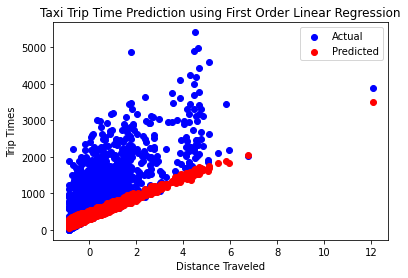

Alpha: 0.5
Prediction RMSE 1st Order = 505.600
Cross Validation RMSE 1st Order = 516.933


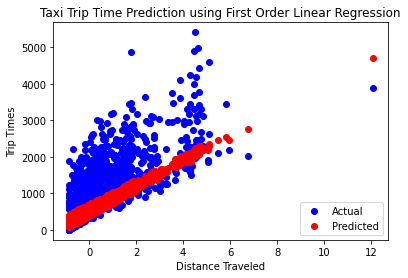

Alpha: 0.01
Prediction RMSE 1st Order = 399.217
Cross Validation RMSE 1st Order = 398.891


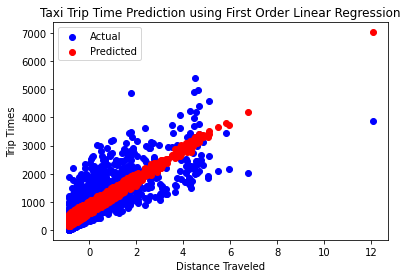

Alpha: 1e-06
Prediction RMSE 1st Order = 399.699
Cross Validation RMSE 1st Order = 398.765


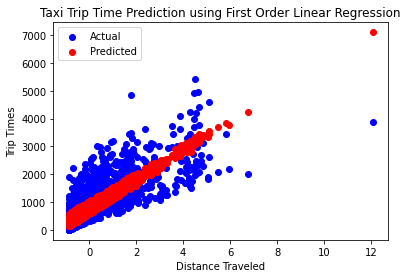

Alpha: 1
Prediction RMSE 2nd Order = 615.167
Cross Validation RMSE 2nd Order = 622.102


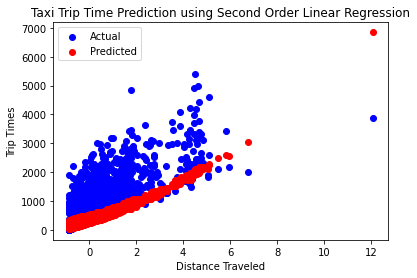

Alpha: 0.5
Prediction RMSE 2nd Order = 513.172
Cross Validation RMSE 2nd Order = 517.254


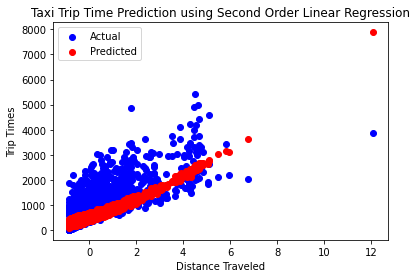

Alpha: 0.01
Prediction RMSE 2nd Order = 382.449
Cross Validation RMSE 2nd Order = 387.100


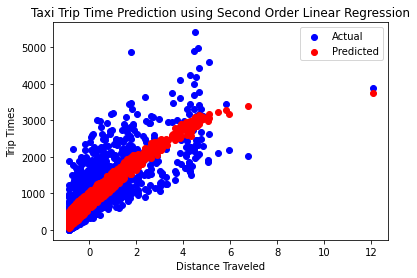

Alpha: 1e-06
Prediction RMSE 2nd Order = 380.897
Cross Validation RMSE 2nd Order = 384.714


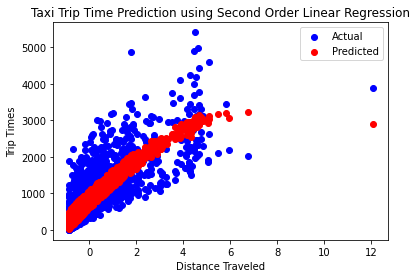

In [0]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import random
from sklearn.metrics.pairwise import haversine_distances
import math
import datetime
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LinearRegressionWithSGD, LabeledPoint
import matplotlib.pyplot as plt

def squaredError(label, prediction):
    return (label-prediction)*(label-prediction)

def calcRMSE(labelsAndPreds):
    sqrSum = labelsAndPreds.map(lambda s: squaredError(s[0],s[1])).sum()
    return math.sqrt(sqrSum/labelsAndPreds.count())

def normalizeFeatures(lp):
    normalizedFeatures = list()
    for i in range(0,len(lp.features)):
        feature = (lp.features[i]-broadcastMean.value[i])/broadcastStdev.value[i]
        if not np.isnan(float(feature)):
            normalizedFeatures.insert(i,feature)
        else: #handle NaN's
            normalizedFeatures.insert(i,0)
    return LabeledPoint(lp.label, normalizedFeatures)

def getNormalizedRDD(nonNormalizedRDD): 
    meanList = list()
    stdevList = list()
    numFeatures = len(nonNormalizedRDD.take(1)[0].features)
    for i in range(0,numFeatures):
        featureRDD = nonNormalizedRDD.map(lambda lp: lp.features[i])
        featureMean = featureRDD.mean()
        featureStdev = featureRDD.stdev()
        meanList.insert(i,featureMean)
        stdevList.insert(i,featureStdev)
    global broadcastMean 
    broadcastMean = sc.broadcast(meanList)
    global broadcastStdev 
    broadcastStdev = sc.broadcast(stdevList)
    returnRDD = nonNormalizedRDD.map(normalizeFeatures)
    return returnRDD

def getDistance(lat1, long1, lat2, long2):
    pickup = [float(lat1), float(long1)]
    dropoff = [float(lat2), float(long2)]
    pickupInRadians = [math.radians(_) for _ in pickup]
    dropOffInRadians = [math.radians(_) for _ in dropoff]
    result = haversine_distances([pickupInRadians, dropOffInRadians])
    return result[0][1] * 6371000/1000

def dateTimeToTuple(dateTime):
    date = datetime.datetime.strptime(dateTime, "%Y-%m-%d %H:%M:%S")
    return (date.year, date.month, date.day, date.hour, date.minute)


def timeToPeriodOneHot(inputHour):
    hour = int(inputHour)
    if hour >= 0 and hour < 6:          # overnight
        return [1,0,0,0]
    elif hour >= 6 and hour < 12:       # morning
        return [0,1,0,0]
    elif hour >= 12 and hour < 18:      # afternoon
        return [0,0,1,0]
    elif hour >= 18 and hour <= 24:     # evening
        return [0,0,0,1]
    else:
        return [0,0,0,0]

def weekdayOrWeekendOneHot(datetimeToCheck):
    dayNum = datetime.datetime.strptime(datetimeToCheck, "%Y-%m-%d %H:%M:%S").weekday()
    if dayNum < 5:                      # weekday
        return [1,0]
    elif dayNum == 5 or dayNum == 6:    # weekend
        return [0,1]
    else:
        return [0,0]
   
def monthToSeasonOneHot(monthToCheck):
    month = int(monthToCheck)

    if month == 12 or month == 1 or month == 2:     # winter
        return [1,0,0,0]
    elif month > 2 and month <= 5:                  # spring
        return [0,1,0,0]
    elif month > 5 and month <= 8:                  # summer
        return [0,0,1,0]
    elif month > 8 and month <= 11:                 # fall
        return [0,0,0,1]
    else:
        return [0,0,0,0]


def extractFields(taxiTripRDD):
    fields = taxiTripRDD.split(',')
    vendor_id = 1 if fields[1] == '1' else 0
    pickup_datetime = fields[2]
    passenger_count = fields[4]
    store_and_fwd_flag = 0 if fields[9] == 'N' else 1
    trip_duration = fields[10]

    pickup_longitude = fields[5]
    pickup_latitude = fields[6]
    dropoff_longitude = fields[7]
    dropoff_latitude = fields[8]

    distance_traveled = getDistance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)

    dateTuple = dateTimeToTuple(pickup_datetime)

    pickup_year = dateTuple[0]
    pickup_season = monthToSeasonOneHot(dateTuple[1])
    pickup_day_type = weekdayOrWeekendOneHot(pickup_datetime)
    pickup_period_of_day = timeToPeriodOneHot(dateTuple[3])
    
    return (int(trip_duration), 
            (int(vendor_id), 
             int(passenger_count), 
             pickup_season[0],              #isWinter
             pickup_season[1],              #isSpring
             pickup_season[2],              #isSummer
             pickup_season[3],              #isFall
             pickup_day_type[0],            #isWeekday
             pickup_day_type[1],            #isWeekend
             pickup_period_of_day[0],       #isOvernight
             pickup_period_of_day[1],       #isMorning
             pickup_period_of_day[2],       #isAfternoon
             pickup_period_of_day[3],       #isNight
             round(distance_traveled, 5)))

def parsePoint(line):
    return LabeledPoint(line[0], line[1])

def transformFeaturesToSecondOrder(RDDPair):
    secondOrderFeatures = list(RDDPair.features)
    for feature in RDDPair.features:
        secondOrderFeatures.append(feature*feature)

    return LabeledPoint(RDDPair.label, tuple(secondOrderFeatures))


dataRDDwithHeader = sc.textFile("dbfs:/FileStore/shared_uploads/luke.couture@ucalgary.ca/train.csv")

# Filter out header row with feature names
header = dataRDDwithHeader.first()
dataRDD = dataRDDwithHeader.filter(lambda row: row != header)

# Take 1% of data
truncatedRDD = dataRDD.sample(False, 0.01, 17)

# Extract Relevant Fields and transform to LabeledPoint
extractedDataRDD = truncatedRDD.map(extractFields)
parsedPointsRDD = extractedDataRDD.map(parsePoint)

# remove any values greater than outlier value
truncatedRDDNoOutliers = parsedPointsRDD.filter(lambda x: x.label < 16000 or x.features[1] > 6)
print(f'outliers removed = {parsedPointsRDD.count()-truncatedRDDNoOutliers.count()}')

# Normalize first order RDD
normalizedParsedPointsRDD = getNormalizedRDD(truncatedRDDNoOutliers)

# Create second order RDD and normalize
truncatedRDDNoOutliersSecondOrder = truncatedRDDNoOutliers.map(transformFeaturesToSecondOrder)
normalizedParsedPointsRDDSecondOrder = getNormalizedRDD(truncatedRDDNoOutliersSecondOrder)


# split training and validation data
weights = [.8, .2] # train/test split
seed = 17
parsedTrainData, parsedValData = normalizedParsedPointsRDD.randomSplit(weights,seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTrainDataSecondOrder, parsedValDataSecondOrder = normalizedParsedPointsRDDSecondOrder.randomSplit(weights,seed)
parsedTrainDataSecondOrder.cache()
parsedValDataSecondOrder.cache()

# Values to use when training the linear regression model
numIters = 500  # iterations
step = 1
alphas = [1, 0.5, 0.01, 1e-06]  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

# calculate baseline RMSE (using average as a guess for each trip's duration) for training and validation data
averageTripDuration = (parsedTrainData.map(lambda trip: trip.label)).mean()
labelsAndPredsTrain = parsedTrainData.map(lambda trip: (trip.label,averageTripDuration))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)
labelsAndPredsVal = parsedValData.map(lambda trip: (trip.label,averageTripDuration))
rmseValBase = calcRMSE(labelsAndPredsVal)
print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))

###################################################################################################################
#                                                                                                                 #
#                                   First Order Model Results                                                     #
#                                                                                                                 #
###################################################################################################################

for a in alphas:
    # create first degree linear regression model
    firstModel = LinearRegressionWithSGD.train(parsedTrainData,numIters,step,miniBatchFrac,initialWeights=None,regParam=a,regType=regType,intercept=useIntercept)

    # calculate RMSE for predictions
    labelsAndPreds = parsedValData.map(lambda lp: (lp.label,firstModel.predict(lp.features)))

    # calculate RMSE for cross validation
    labelsAndPredsTrain1 = parsedTrainData.map(lambda lp: (lp.label,firstModel.predict(lp.features)))

    rmseValLR1 = calcRMSE(labelsAndPreds)
    rmseTrainLR1 = calcRMSE(labelsAndPredsTrain1)
    print(f'Alpha: {a}')
    print('Prediction RMSE 1st Order = {0:.3f}'.format(rmseValLR1))
    print('Cross Validation RMSE 1st Order = {0:.3f}'.format(rmseTrainLR1))

    predictions = labelsAndPreds.map(lambda labelAndPred: labelAndPred[1]).collect()
    yVals = parsedValData.map(lambda lp: lp.label).collect()
    xVals = parsedValData.map(lambda lp: lp.features[-1]).collect()


    plt.scatter(xVals, yVals, color='blue', label='Actual')
    plt.scatter(xVals, predictions, color='red', label='Predicted')
    plt.xlabel('Distance Traveled')
    plt.ylabel('Trip Times')
    plt.title('Taxi Trip Time Prediction using First Order Linear Regression')
    plt.legend()
    plt.show()


###################################################################################################################
#                                                                                                                 #
#                                   Second Order Model Results                                                    #
#                                                                                                                 #
###################################################################################################################

for a in alphas:
    # create second degree linear regression model
    secondModel = LinearRegressionWithSGD.train(parsedTrainDataSecondOrder,numIters,step,miniBatchFrac,initialWeights=None,regParam=a,regType=regType,intercept=useIntercept)

    # calculate RMSE for predictions
    labelsAndPreds2 = parsedValDataSecondOrder.map(lambda lp: (lp.label,secondModel.predict(lp.features)))

    # calculate RMSE for cross validation
    labelsAndPredsTrain2 = parsedTrainDataSecondOrder.map(lambda lp: (lp.label,secondModel.predict(lp.features)))

    rmseValLR2 = calcRMSE(labelsAndPreds2)
    rmseTrainLR2 = calcRMSE(labelsAndPredsTrain2)
    print(f'Alpha: {a}')
    print('Prediction RMSE 2nd Order = {0:.3f}'.format(rmseValLR2))
    print('Cross Validation RMSE 2nd Order = {0:.3f}'.format(rmseTrainLR2))

    predictions2 = labelsAndPreds2.map(lambda labelAndPred: labelAndPred[1]).collect()

    plt.scatter(xVals, yVals, color='blue', label='Actual')
    plt.scatter(xVals, predictions2, color='red', label='Predicted')
    plt.xlabel('Distance Traveled')
    plt.ylabel('Trip Times')
    plt.title('Taxi Trip Time Prediction using Second Order Linear Regression')
    plt.legend()
    plt.show()
